In [20]:
import pandas as pd
df = pd.read_csv('questions01.csv')
df.head()

,classs,question
0,Description,What is Filename injection Path traversel ?
1,Description,What does Filename injection Path traversel me...
2,Solution,How to resolve PII protection ?
3,Description,Tell me something about Filename injection Pat...
4,Description,Filename injection Path traversel


In [21]:
from io import StringIO

col = ['classs', 'question']
df = df[col]
df = df[pd.notnull(df['question'])]

df.columns = ['classs', 'question']



In [22]:
df['category_id'] = df['classs'].factorize()[0]

In [23]:
category_id_df = df[['classs', 'category_id']].drop_duplicates().sort_values('category_id')


In [24]:
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'classs']].values)
df.head()

,classs,question,category_id
0,Description,What is Filename injection Path traversel ?,0
1,Description,What does Filename injection Path traversel me...,0
2,Solution,How to resolve PII protection ?,1
3,Description,Tell me something about Filename injection Pat...,0
4,Description,Filename injection Path traversel,0


In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.question).toarray()
labels = df.category_id
features.shape

(5081, 1266)

In [28]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for classs, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(classs))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Code':
  . Most correlated unigrams:
. example
. code
  . Most correlated bigrams:
. sample code
. code example
# 'Description':
  . Most correlated unigrams:
. tell
. code
  . Most correlated bigrams:
. sample code
. code example
# 'Solution':
  . Most correlated unigrams:
. defend
. resolve
  . Most correlated bigrams:
. sample code
. code example


In [29]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['question'], df['classs'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
priya
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [30]:
print(clf.predict(count_vect.transform(["what is csrf?"])))

['Description']


In [34]:
print(clf.predict(count_vect.transform(["show me some example to mitigate csrf"])))

['Code']


In [35]:
print(clf.predict(count_vect.transform(["how to mitigate csrf"])))

['Solution']


<IPython.core.display.Javascript object>


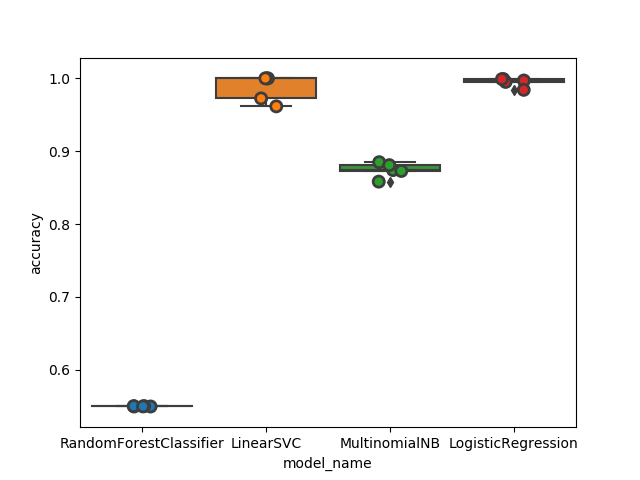

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()



In [44]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.986809
LogisticRegression        0.994880
MultinomialNB             0.874235
RandomForestClassifier    0.549892
Name: accuracy, dtype: float64

In [46]:
model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)



In [47]:
model.fit(features, labels)

N = 2
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(Product))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'Code':
  . Top unigrams:
       . code
       . example
  . Top bigrams:
       . code example
       . sample code
# 'Description':
  . Top unigrams:
       . tell
       . know
  . Top bigrams:
       . malicious code
       . sandboxing malicious
# 'Solution':
  . Top unigrams:
       . mitigate
       . resolve
  . Top bigrams:
       . mitigate enforce
       . resolve enforce


In [48]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['classs'].unique()))

             precision    recall  f1-score   support

Description       1.00      1.00      1.00       903
   Solution       1.00      1.00      1.00       517
       Code       1.00      1.00      1.00       257

avg / total       1.00      1.00      1.00      1677



In [52]:
print(model.predict(X_test))

[0 1 0 ... 0 1 2]
